In [62]:
# Importing Libraries
import rasterio
import imageio.v3 as iio
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import gdal

In [63]:
# https://here.isnew.info/how-to-save-a-numpy-array-as-a-geotiff-file-using-gdal.html

def read_geotiff(filename):
    ds = gdal.Open(filename)
    band = ds.GetRasterBand(1)
    arr = band.ReadAsArray()
    return arr, ds


def write_geotiff(filename, arr, in_ds):
    if arr.dtype == np.float32:
        arr_type = gdal.GDT_Float32
    else:
        arr_type = gdal.GDT_Int32

    driver = gdal.GetDriverByName("GTiff")
    out_ds = driver.Create(filename, arr.shape[1], arr.shape[0], 1, arr_type)
    out_ds.SetProjection(in_ds.GetProjection())
    out_ds.SetGeoTransform(in_ds.GetGeoTransform())
    band = out_ds.GetRasterBand(1)
    band.WriteArray(arr)
    band.FlushCache()
    band.ComputeStatistics(False)


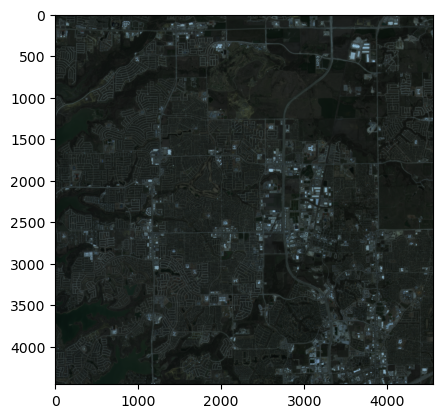

In [64]:
# Load the 8-band satellite image data
# fp = '../../../data/frisco-change/clip_2023_sr_8b.tif'
fp = '../../../data/frisco-change/clip_2022_sr_8b.tif'


with rasterio.open(fp) as src:
    image = src.read()

# Select the desired bands
blue = image[1, :, :]
green = image[3, :, :]
red = image[5, :, :]

# Normalize the bands
blue = blue / blue.max()
green = green / green.max()
red = red / red.max()

# Combine the bands into an RGB image
rgb = np.stack([red, green, blue], axis=2)

# Display the RGB image
plt.imshow(rgb)
plt.show()


In [65]:
# Read the satellite image file into a numpy array
image_data = iio.imread(filename)
# np.save('satellite_image.npy', image)

# image_data = np.load('satellite_image.npy')
# print(image_data.shape)

image_data_2d = image_data.reshape(-1, image_data.shape[-1] )
print(image_data_2d.shape)


(20256792, 8)



## Calculating PCA


In [66]:
# Initialize the PCA model with 3 components
pca = PCA(n_components=8)

# Fit the model to the image data
pca.fit(image_data_2d)

# Transform the data into the PCA space
pca_results = pca.transform(image_data_2d)
pca_results.shape

(20256792, 8)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


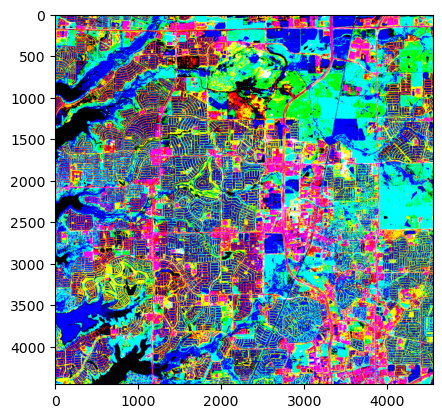

In [67]:
# Reshape the PCA results into a 2D image
pca_1 = pca_results[:, 0].reshape(image_data.shape[0], image_data.shape[1] )
pca_2 = pca_results[:, 1].reshape(image_data.shape[0], image_data.shape[1] )
pca_3 = pca_results[:, 2].reshape(image_data.shape[0], image_data.shape[1] )

# Combine the bands into an RGB image
pca_rgb = np.stack([pca_1, pca_2, pca_3], axis=2)

# Display the RGB image
plt.imshow(pca_rgb)
plt.show()


## Classifying the PCA Results Using K-means



In [68]:
# # Define the number of clusters
n_clusters = 5

# Initialize the k-means model
kmeans = KMeans(n_clusters=n_clusters, random_state=0, n_init='auto')

# Fit the model to the data
kmeans.fit(pca_results)

# Predict the cluster assignments for each pixel
labels = kmeans.predict(pca_results)
print(labels.shape)
# Reshape the labels back into the original image shape
labels = labels.reshape(image_data.shape[0], image_data.shape[1])
print(labels.shape)

# Plot the image and display the results
plt.imshow(labels, cmap='turbo')
plt.show()

In [ ]:
write_geotiff('../../../data/frisco-change/aoi/2022_5cluster_kmeans.tif', labels, ds)
write_geotiff('../../../data/frisco-change/aoi/2022_pca1.tif', pca_1, ds)
write_geotiff('../../../data/frisco-change/aoi/2022_pca2.tif', pca_2, ds)
write_geotiff('../../../data/frisco-change/aoi/2022_pca3.tif', pca_3, ds)